## import other libaries

In [2]:

import pathlib 
PATH_EXPORT = pathlib.Path('../results/')

In [3]:
import datetime
import matplotlib.pyplot as plt
import numpy as np 

In [4]:
def make_polar_axis():
    ''' returns matploblib.axes object with polar projection.
    The axes are set up to display date in the form of:
        p = (r=azimuth, theta=zenith)
    '''    
    ax = plt.subplot(111,projection='polar')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_rlim(0,90)
    ax.set_xlabel('azimuth [°]')
    ax.text(np.radians(25),105,'zenith [°]',
        rotation=0,ha='left',va='bottom')
    return ax

## basic example

In [5]:
from pysolar import solar

In [6]:
latitude = 52.37
longitude = 9.73
date = datetime.datetime.fromisoformat('2020-06-01T15:13:01+00:00')

In [7]:
# get_position()
solar.get_position(latitude, longitude, date)

(259.05480671887864, 36.47705999738487)

In [8]:
# get_azimuth()
solar.get_azimuth(latitude, longitude, date)

259.05480671887864

In [9]:
# get_longitude()
solar.get_altitude(latitude, longitude, date)

36.47705999738487

## advanced example

In [21]:
# define dates
dates = [datetime.datetime.strptime(f'2019/{i} 12:00:00+0000','%Y/%j %X%z') 
         for i in range(1,356)]
dates[0:5]

[datetime.datetime(2019, 1, 1, 12, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 1, 2, 12, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 1, 3, 12, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 1, 4, 12, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 1, 5, 12, 0, tzinfo=datetime.timezone.utc)]

In [22]:
# calculate azimuths
azimuths = np.array([solar.get_azimuth(latitude, longitude, date) 
                     for date in dates])

In [23]:
# calculate zeniths
zeniths = np.array([90-solar.get_altitude(latitude, longitude, date) 
                    for date in dates])

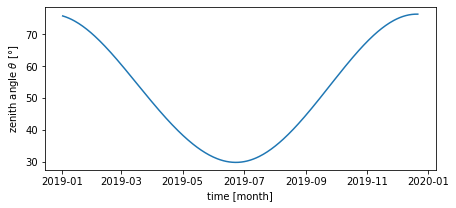

In [32]:
# show results
ax= plt.subplots(1,1, figsize=(7,3))
plt.plot(dates, zeniths)
plt.xlabel('time [month]')
plt.ylabel('zenith angle $\\theta$ [°]')
plt.savefig(PATH_EXPORT/'example.png', dpi=300, bbox_inches='tight')

plt.show()

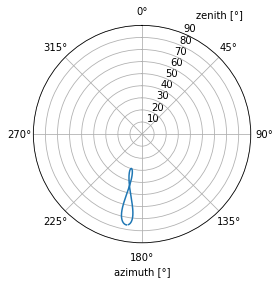

In [25]:
# use make_polar_axis()
ax = make_polar_axis()
ax.plot(np.radians(azimuths), zeniths)

# plt.show()

## and more advanced usecase

In [26]:
import pandas as pd
import time

In [27]:
def calc_spa(df, lat, lon):
    df = df.copy()
    df['altitude'] = df.apply(lambda r: solar.get_altitude(lat, lon, r['time'].to_pydatetime()), axis=1)
    df['azimuth'] = df.apply(lambda r: solar.get_azimuth(lat, lon, r['time'].to_pydatetime()), axis=1)
    df['sza'] = 90-df['altitude']
    df['doy'] = df.apply(lambda r: r.time.dayofyear, axis=1)
    return df

# PARAMETERS
filename = 'data_2019_in_hours.csv'
lat = 52.37
lon = 9.73
tz = 'UTC'

start = time.perf_counter()
# GENERATE DATASET
data = pd.DataFrame({
    'time' :pd.date_range('2019-01-01 00:00:00', '2020-01-01', freq='H', tz=tz)
})
data = calc_spa(data, lat, lon)
data.to_csv(filename, index=False)

print(len(data), 'calculations were generated and saved in', time.perf_counter()-start, 's')

8761 calculations were generated and saved in 22.87065850000363 s


In [28]:
data = pd.read_csv('data_2019_in_hours.csv', parse_dates=[0])
subset = data[data.sza<90]
subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4444 entries, 8 to 8751
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   time      4444 non-null   datetime64[ns, UTC]
 1   altitude  4444 non-null   float64            
 2   azimuth   4444 non-null   float64            
 3   sza       4444 non-null   float64            
 4   doy       4444 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(3), int64(1)
memory usage: 208.3 KB


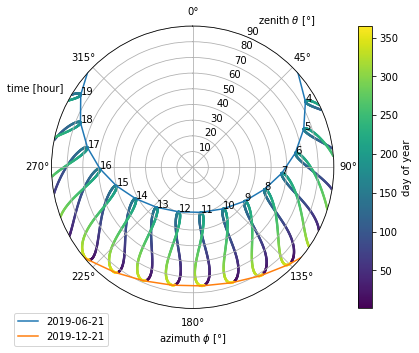

sun position angles for Hannover (52.4,9.7)
every hour in 2019


In [40]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection='polar')

# scatter all data
points = ax.scatter(np.radians(subset.azimuth), subset.sza, c=subset.doy, s=2)
ax.figure.colorbar(points, label='day of year')

# add highest and lowest point (['2019-06-21', '2019-12-21'])
for d,d2 in [('2019-06-21','2019-06-22'), ('2019-12-21','2019-12-22')]:
    s1 = data.loc[(data['time'] >= d) 
            & (data['time'] <= d2)]
    ax.plot(np.radians(s1.azimuth), s1.sza, label=d)

# add hour label
for hour in np.unique(subset.time.dt.hour):
    s1 = subset.loc[subset['time'].dt.hour == hour]
    pos = subset.loc[s1.sza.idxmin()]
    ax.text(np.radians(pos['azimuth']), pos['sza'], str(hour))
    
# adjust the layout
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rlim(0,90)
ax.set_xlabel('azimuth $\\phi$ [°]')
ax.text(np.radians(25),98,'zenith $\\theta$ [°]',
        rotation=0,ha='left',va='bottom')
ax.text(np.radians(300),95,'time [hour]',
        rotation=0,ha='right',va='bottom')
ax.legend(loc='lower left',bbox_to_anchor=(-0.15,-0.15))
plt.tight_layout()
plt.savefig(PATH_EXPORT/'example_adv.png', dpi=400, bbox_inches='tight')
plt.show()
print(f'sun position angles for Hannover ({lat:2.1f},{lon:2.1f})\nevery hour in 2019')